# I. IMPORTS

In [1]:
# All relevant imports for this file are done here. 
# Run the following in terminal if errors are obtained: set DJANGO_SETTINGS_MODULE=ms2ldaviz.settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
basedir = 'C:\\Users\\rpetr\\OneDrive\\Desktop\\DISS_CODE\\ms2ldaviz\\ms2ldaviz'
sys.path.append(basedir)
import django
import json
django.setup()
from basicviz.models import Experiment, Alpha, Mass2MotifInstance, FeatureInstance, Feature, Document, Mass2Motif, DocumentMass2Motif, FeatureMass2MotifInstance
import numpy as np
import pylab as plt
import csv
from scipy.special import polygamma as pg
from scipy.special import psi as psi

MEDIA_ROOT is C:\Users\rpetr\OneDrive\Desktop\DISS_CODE\ms2ldaviz\ms2ldaviz\media


# II. COMMON VARIABLES

In [2]:
# Choose experiment ID manually from database. Small number is used for normalisation and e-step below. 
experiment_id=190 
experiment = Experiment.objects.get(id=experiment_id)
SMALL_NUMBER = 1e-100

# III. CORPUS SETUP

In [3]:
# Get all words/features in the database relevant for the experiment. 
features = Feature.objects.filter(experiment_id=experiment)
experiment_words = []
for f in features:
     if f.id not in experiment_words: 
        experiment_words.append(f.id)

In [4]:
# Match each word to an index. 
unique_words = {}
index = 0
for word in experiment_words:
    if word not in unique_words.keys():
        unique_words.update({word:index})
        index+=1

In [5]:
# This prototype uses a single document. The value is known beforehand. Manual input here. 
# BELOW COMMENTS FOR REFERENCE:
# 269485	eawag_0503.ms
# 270314	washington_0978.ms
# 270414	eawag_0758.ms
# 271247	eawag_0759.ms
# 269323 	eawag_0730.ms
experiment_docs=[269323]

In [6]:
# Map each document to a specific ID. 
unique_docs = {}
index = 0 
for doc in experiment_docs: 
    unique_docs.update({doc:index})
    index+=1

In [7]:
# Get words/features for all documents chosen. The output columns are doc_id, word_id and intensity.
feature_instances = FeatureInstance.objects.filter(document_id__in=unique_docs.keys(), feature_id__in=unique_words.keys())
doc_word_data = []
for f in feature_instances:
    doc_word_data.append([unique_docs[int(f.document_id)], unique_words[int(f.feature_id)], f.intensity])

In [8]:
# Create the corpus in {doc_id:{word_id:word_count}} form.
# Inner dictionary is created first {word:word_count} and then added to doc dictionary key.
temp_dict1 = {}
temp_dict2 = {}
for line in doc_word_data: 
    doc = line[0]
    word = line[1]
    count = line[2]
    temp_dict1.update({word:count})
    if doc not in temp_dict2.keys():
        temp_dict2.update({doc:temp_dict1})
corpus_dict = temp_dict2

In [9]:
# Get topics for the experiment. Map them to indices. 
mi = Mass2Motif.objects.filter(experiment=experiment)
unique_topics = {}
index = 0
for m in mi: 
    unique_topics.update({m.id:index})
    index+=1

# IV. GET ALPHA

In [10]:
# Get Alphas from database. Transform them to topic_count length vector.
al = Alpha.objects.filter(mass2motif__experiment=experiment).order_by('mass2motif')
alphas = {}
for a in al:
    alphas.update({unique_topics[a.mass2motif_id]: a.value})
n_motif = len(alphas)
alpha_vec = np.zeros(n_motif)
for pos,val in alphas.items():
    alpha_vec[pos] = val

In [11]:
# Rename for ease. 
alpha_vector = alpha_vec

# V. GET BETA

In [12]:
# Get the Beta values from the database in list form -> topic, word, probability.
beta_pre_pivot = []
mi = Mass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
for m in mi:
    beta_pre_pivot.append([unique_topics[m.mass2motif_id], unique_words[m.feature_id], m.probability]) 

In [13]:
# Create the Beta matrix.
output_arr_beta = np.array(beta_pre_pivot)
K = len(unique_topics)
W = len(unique_words)
pivot_table = np.zeros((K, W)).astype('float')
i = 0
max = len(beta_pre_pivot)
while i<max:
    pivot_table[int(output_arr_beta[i][0]),int(output_arr_beta[i][1])]=output_arr_beta[i][2]
    i+=1

In [14]:
# Normalise the beta matrix. Beta is now ready to be used in the E-step.
pivot_table_normalised = pivot_table
i = 0
while i<K: 
    row = pivot_table_normalised[i, :]
    adjusted_row = row + SMALL_NUMBER
    normalised_row = adjusted_row / np.sum(adjusted_row)
    np.sum(normalised_row)
    pivot_table_normalised[i, :] = normalised_row
    i+=1

# VI. GET ORIGINAL GAMMA(IN NORMALISED FORM THETA)

In [15]:
# Get original normalised Gamma values from experiment dictionary input. 
theta = DocumentMass2Motif.objects.filter(document_id__in=experiment_docs)
output_data_theta = []
for t in theta:
    output_data_theta.append([unique_docs[int(t.document_id)], unique_topics[int(t.mass2motif_id)], t.probability])

# VII. GET ORIGINAL PHI 

In [16]:
# Get feature instances. 
feature_instance = FeatureInstance.objects.filter(document_id__in=experiment_docs)
feature_instance_join = {}
for i in feature_instance:
    feature_instance_join.update({int(i.id):[int(i.document_id), int(unique_words[i.feature_id])]})

In [17]:
# Connect docs, words and topic arrays(distributions) to create phi.
feature_m2m_instance = FeatureMass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
phi_list = []
for i in feature_m2m_instance:
    if i.featureinstance_id in feature_instance_join.keys():
        phi_list.append([feature_instance_join[int(i.featureinstance_id)][0], unique_topics[int(i.mass2motif_id)], feature_instance_join[int(i.featureinstance_id)][1],i.probability])

In [18]:
# This gives the original Phi, which in abstract terms is a 3D matrix -> docs * topics * words.
# Convert phi ot numpy array format. 
phi_original = []
for line in phi_list: 
    phi_original.append([line[0],line[2],line[1],line[3]])
phi_original_array = np.array(phi_original)

# VIII. E-STEP 

## Step 0 - E-step variables

In [19]:
# Define any missing variables for the e-step.
corpus = corpus_dict
beta_matrix = pivot_table_normalised

## Step 1 - Initialise phi matrix

In [20]:
# Initialise Phi in the format -> {doc:{word:[topic_array]}}
phi_matrix={}
for doc in corpus: 
    d = int(doc)
    phi_matrix[d] = {}
    for word in corpus[doc]:
        w = int(word)
        phi_matrix[d][w]=np.zeros(K)

## Step 2 - initialise gamma matrix

In [21]:
# Initialise Gamma matrix. 
# As the prototype has only 1 document - we get a gamma vector of size K.
# doc_total = words/document
gamma_matrix=np.zeros((int(len(corpus)),int(K))) #3x500 shape
for doc in corpus:
    doc_total=0.0
    for word in corpus[doc]:
        doc_total += corpus[doc][word]
    gamma_matrix[int(doc),:] = alpha_vector + 1.0*(doc_total/K)

## Step 3 - repeat until convergence loop

In [22]:
# The code below has been refactored from lda.py at https://github.com/sdrogers/ms2ldaviz/blob/master/lda/code/lda.py
# This is an implementation of Blei's loop as described on http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, page 1005.
test_list = []
iterations=1000
n_words = int(len(unique_words))
temp_beta = np.zeros((K, n_words))
current_gamma = np.copy(gamma_matrix)
for i in range(iterations):   
    prev_gamma = np.copy(current_gamma)
    for doc in corpus:
        d = int(doc)
        doc_dict = corpus[doc]
        temp_gamma = np.zeros(K) + alpha_vector
        for word in doc_dict:  
            w = int(word)
            log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[d,:]).T
            log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
            phi_matrix[d][w] = log_phi_matrix/log_phi_matrix.sum()
            temp_gamma += phi_matrix[d][w]*corpus[doc][word]
            temp_beta[:,w] += phi_matrix[d][w] * corpus[doc][word]
        gamma_matrix[d,:] = temp_gamma
        pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
        gamma_matrix[d,pos] = SMALL_NUMBER
    current_gamma = np.copy(gamma_matrix)
    gamma_diff = ((current_gamma - prev_gamma)**2).sum()
    test_list.append([i, gamma_diff])

# IX. COMPARISON OF GAMMA & PHI (original vs calculated in prototype)

## Normalised Gamma (Theta) Comparison

In [23]:
# Transform original gamma into a K-length vector. 
gamma_vector_original = np.zeros(K) 
for line in range(len(output_data_theta)):
    pos = int(output_data_theta[line][1])
    prob = output_data_theta[line][2]
    gamma_vector_original[pos] = prob

In [24]:
# Normalise original gamma vector. 
gamma_vector_original += SMALL_NUMBER
gamma_vector_original /= np.sum(gamma_vector_original)

In [25]:
# Create and normalise vector for calculated gamma. 
gamma_vector_calculated = np.zeros(K) 
gamma_vector_calculated = np.copy(gamma_matrix[0])
gamma_vector_calculated /= np.sum(gamma_vector_calculated)

In [26]:
# Test how the gamma values compare. Format-> [original_gamma, calculated_gamma, difference]
gamma_compare = np.zeros([K,3])
for i in range(K):
    gamma_compare[i,0] = gamma_vector_original[i]
    gamma_compare[i,1] = gamma_vector_calculated[i]
    gamma_compare[i,2] = abs(gamma_compare[i,0] - gamma_compare[i,1]) 
print('Max difference between gammas: ' + str(gamma_compare[:,2].max()))

Max difference between gammas: 0.24323430341671726


In [27]:
# CSV export of gamma value comparison. 
np.savetxt("compare_gamma_"+str(experiment_docs[0])+".csv", gamma_compare, delimiter=",", fmt="%s")

## Phi comparison (for words above min "noise" intensity)

In [28]:
#Get the words from de corpus dict that have the highest intensity. 
materiality_level = 20
material_words = []
for doc in corpus_dict: 
    for word in corpus_dict[doc]:
        w = corpus_dict[doc][word]
        if int(w) > materiality_level:
            material_words.append([int(word), w]) 

In [29]:
# Create material words dictionary too if needed. 
material_words_dict = {}
for line in material_words:
    material_words_dict.update({line[0] : line[1]})

In [30]:
# Make array of material words list.
material_words_array = np.array(material_words)

In [31]:
# Sort the array descending order (optional). 
material_words_array = material_words_array[(-material_words_array)[:,1].argsort()]

In [32]:
# Choose material words for comparison loop.
material_words_list = list(material_words_array[:,0])

In [33]:
# Create list for phi comparison, each line having doc/word/topic/original_phi/calculated_phi/difference/word_intensity as columns.
phi_comparison = []
for line in phi_list: 
    line_word = int(line[2])
    if line_word in material_words_list:
        line_doc = unique_docs[line[0]]
        line_topic = int(line[1])
        line_original_prob = line[3]
        line_prob = phi_matrix[line_doc][line_word][line_topic]
        phi_diff = abs(line_original_prob-line_prob)
        intensity = material_words_dict[line_word]
        phi_comparison.append([line_doc, line_word, line_topic, line_original_prob, line_prob, phi_diff, intensity])

In [34]:
# Create array from list. 
phi_comparison_array = np.array(phi_comparison)

In [35]:
# Check the maximum difference between phi's. 
max_phi_diff = list(phi_comparison_array[:,5])
max_phi_diff = [float(i) for i in max_phi_diff]
max_phi_diff.sort()
max_phi_diff = max_phi_diff[-1]
print('Max difference between phi\'s: ' + str(max_phi_diff))

Max difference between phi's: 0.89429858354


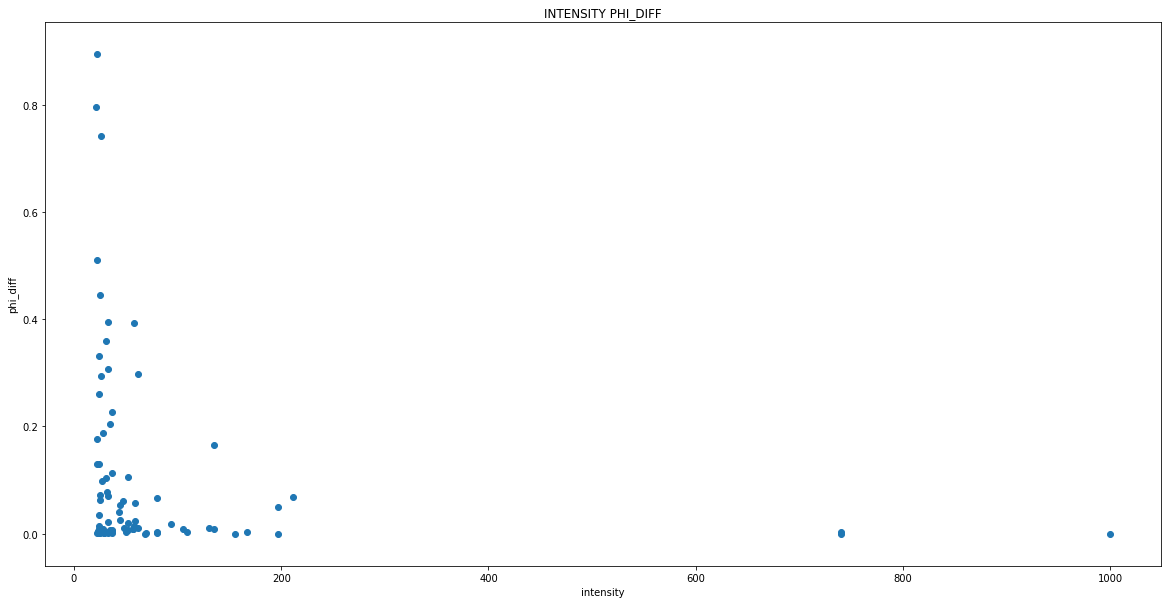

In [48]:
# Plot word intensity on x axis and phi difference on y axis on a scatterplot. 
phi_comparison_intenphi = np.copy(phi_comparison_array[:,5:])
x = phi_comparison_intenphi[:,1]
y = phi_comparison_intenphi[:,0]
fig = plt.figure()
scatterplot = fig.add_subplot(1,1,1)
plt.scatter(x,y)
fig.set_size_inches(20,10)
plt.title("INTENSITY PHI_DIFF")
plt.xlabel("intensity")
plt.ylabel("phi_diff")
plt.show()
fig.savefig(str(experiment_docs[0])+".png")

In [46]:
# CSV export of phi comparison. 
np.savetxt("compare_phi_"+str(experiment_docs[0])+".csv", phi_comparison_array, delimiter=",", fmt="%s")

# Theta differences -> PROTOTYPE02: is it due to thresholding? 

In [47]:
# Check the material and immaterial words for each topic to see if theta differences are due to thresholding. 
topics_tested = np.array(output_data_theta)[:,1]
temp =[]  
for t in topics_tested: 
    temp.append(int(t))
topics_tested = temp
print("topic", "material", "immaterial")
for topic in topics_tested: 
    topic_tested = topic
    count_material = 0
    count_immaterial = 0
    for line in phi_original: 
        if line[2] == topic_tested:
            if line[1] not in material_words_list:
                count_immaterial += 1
            else:
                count_material += 1
    print(topic_tested, count_material, count_immaterial)

('topic', 'material', 'immaterial')
(94, 52, 572)
(286, 15, 260)
(200, 1, 233)
(414, 3, 0)
(499, 3, 27)


[[0, 94, 0.902611552679438],
 [0, 286, 0.0340671553770332],
 [0, 200, 0.0186782260549867],
 [0, 414, 0.0109110112103501],
 [0, 499, 0.0158815907979228]]